# Demo - VAEs - Variational Auto Encoders

# Google Community Summit LATAM

Dr. Ahirton Lopes

* Introdução

Os Variational Autoencoders (VAEs) são um tipo de rede neural generativa que aprende a representar dados em um espaço latente de menor dimensão. Essa representação latente pode ser utilizada para gerar novos dados que se assemelham aos dados de treinamento. No contexto da moda, VAEs podem ser empregados para criar novos designs de roupas a partir de um conjunto de exemplos existentes.

* O Dataset Fashion MNIST

O Fashion MNIST é um dataset composto por 70.000 imagens em preto e branco de 28x28 pixels, representando 10 categorias diferentes de roupas. Ele é frequentemente utilizado como um ponto de partida para experimentos em aprendizado de máquina, pois é mais desafiador que o dataset MNIST original (dígitos escritos à mão).

* O que são Variational Autoencoders?

Encoder: A primeira parte de um VAE, que mapeia as imagens de entrada para um espaço latente.

Espaço Latente: Um espaço de menor dimensão onde cada ponto representa uma possível imagem.

Decoder: A segunda parte de um VAE, que mapeia os pontos do espaço latente de volta para imagens.
Por que usar VAEs?

Geração de Novos Dados: VAEs podem gerar novas imagens que se assemelham aos dados de treinamento, mas não são cópias exatas.

Inferência: VAEs podem ser usados para inferir propriedades latentes dos dados, como o estilo ou a categoria de uma imagem.

Interpolação: É possível interpolar entre dois pontos no espaço latente para criar novas imagens que são uma mistura dos dois pontos originais.

In [26]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import random

In [27]:
# Use randomseed para resultados mais consistentes
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # flag presente no tf 2.0+
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [28]:
from tensorflow.keras.datasets import fashion_mnist


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


<h2>Available Labels/Classes in Fashion Mnist dataset</h2>

<table align="left">
<thead>
<tr>
<th align="center">Label</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td align="center">0</td>
<td>T-shirt/top</td>
</tr>
<tr>
<td align="center">1</td>
<td>Trouser</td>
</tr>
<tr>
<td align="center">2</td>
<td>Pullover</td>
</tr>
<tr>
<td align="center">3</td>
<td>Dress</td>
</tr>
<tr>
<td align="center">4</td>
<td>Coat</td>
</tr>
<tr>
<td align="center">5</td>
<td>Sandal</td>
</tr>
<tr>
<td align="center">6</td>
<td>Shirt</td>
</tr>
<tr>
<td align="center">7</td>
<td>Sneaker</td>
</tr>
<tr>
<td align="center">8</td>
<td>Bag</td>
</tr>
<tr>
<td align="center">9</td>
<td>Ankle boot</td>
</tr>
</tbody>
</table>

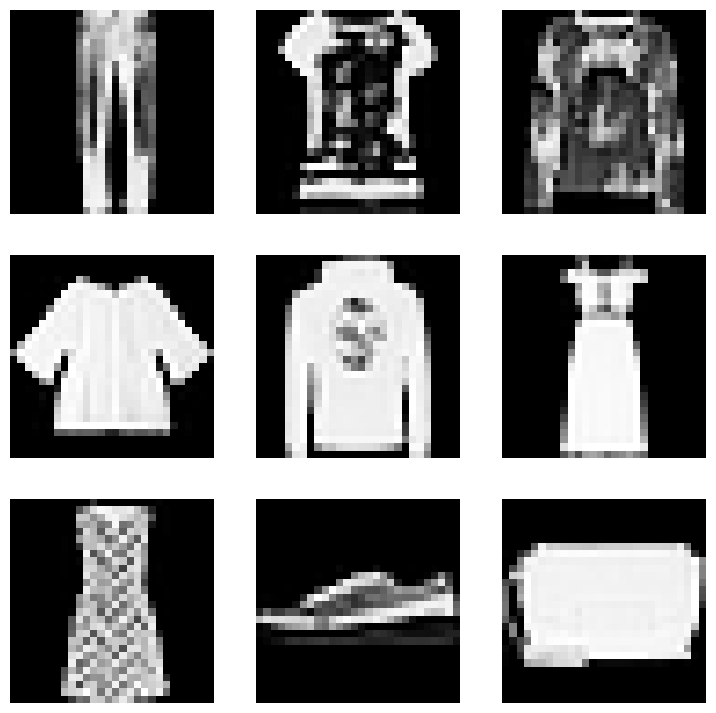

In [29]:
plt.figure(figsize=(9, 9))

# Escolhendo 9 amostras de 60K disponíveis no conjunto de treino
rndSamples = np.random.choice(60000, 9)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[rndSamples[i]], cmap="Greys_r")
    plt.axis('off')

plt.show();

In [30]:
dataset = np.concatenate([x_train, x_test], axis=0)
# Converte imagens de 28x28 para 28x28x1 como camadas convolucionais esperam 3 canais
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

In [31]:
from tensorflow import keras
from tensorflow.keras import layers


# Crie uma camada de amostragem onde definimos a reparametrização
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [32]:
def buildEncoder(latentDim, encoderInputs):

# Dado um batch de imagens, o bloco convolucional extrai os recursos
  l1 = keras.models.Sequential([
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])

#passa as entradas pelo bloco convolucional
  x = l1(encoderInputs)

# uma camada dedicada para aprender a média em paralelo
  zMean = layers.Dense(latentDim, name="z_mean")(x)

# uma camada dedicada para aprender a variação em paralelo
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

# agora o truque de reparametrização para encontrar z como definido por média e variância
  z = SamplingLayer()([zMean, zLogVar])

  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")


# aciona a função para realmente construir o modelo
encoderInputs = keras.Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 256)            │        878,144 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            514 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            514 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_layer_1          │ (None, 2)              │              0 │ z_mean[0][0],          │
│ (SamplingLayer)           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 879,172 (3.35 MB)

 Trainable params: 879,172 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
def buildDecoder(latentInputs):

  l1 = keras.models.Sequential([
    layers.Dense(7*7*64, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((7,7,64)),
    layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
  ])

  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

# construindo o modelo real
latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 28, 28, 1)           │         157,633 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

## Funções de perda (loss)


In [34]:
# A função de primeira perda é a perda de reconstrução, que penaliza imagens que não sejam semelhantes às imagens originais.

def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),
          axis=(1, 2)
      )
  )

In [35]:
# Função de perda de divergência de Kullback-Liebler que penaliza o modelo se ele aprender
# uma distribuição de probabilidade "z" diferente da distribuição de probabilidade original dos dados "X".

def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
          axis=1
      )
  )

In [36]:
# Agora vamos combiná-los na função de perda total

def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

In [37]:
# Como estamos usando uma função de perda personalizada em mu e sigma, precisamos substituir como a perda é calculada.
# Precisamos comparar X_original e X_reconstructed ao mesmo tempo enquanto calculamos a perda de Kullback-Liebler (KL).

class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    # registra a perda total como uma métrica observável no histórico de treinamento do modelo
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")

  # Todas sendo métricas observáveis
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  # Agora calcule a perda + calcule os gradientes + atualize os pesos
  def train_step(self, data):
    # A fita de gradiente é uma gravação de todos os gradientes para o treinável
    # pesos que precisam ser atualizados
    with tf.GradientTape() as tape:

 # caminho para frente
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)
        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)

 # caminho para trás

    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

# acompanhando a perda

    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

# retorna a perda do objeto histórico

    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

## Treinando o modelo

In [38]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(dataset, epochs=32, batch_size=128)

Epoch 1/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - ce_loss: 350.9591 - kl_loss: 2.8014 - total_loss: 359.3634
Epoch 2/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - ce_loss: 268.3695 - kl_loss: 4.4355 - total_loss: 281.6760
Epoch 3/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - ce_loss: 263.8988 - kl_loss: 4.6179 - total_loss: 277.7525
Epoch 4/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - ce_loss: 261.8850 - kl_loss: 4.7372 - total_loss: 276.0965
Epoch 5/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - ce_loss: 259.9417 - kl_loss: 4.8054 - total_loss: 274.3578
Epoch 6/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - ce_loss: 258.7106 - kl_loss: 4.8713 - total_loss: 273.3246
Epoch 7/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - ce_loss: 258.0369 - kl_loss: 4.9121 - total_loss: 272.7732
Epoch 8/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - ce_loss: 256.9543 - kl_loss: 4.9514 - total_loss: 271.8085
Epoch 9/32
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - ce_loss: 256.4635 - kl_loss

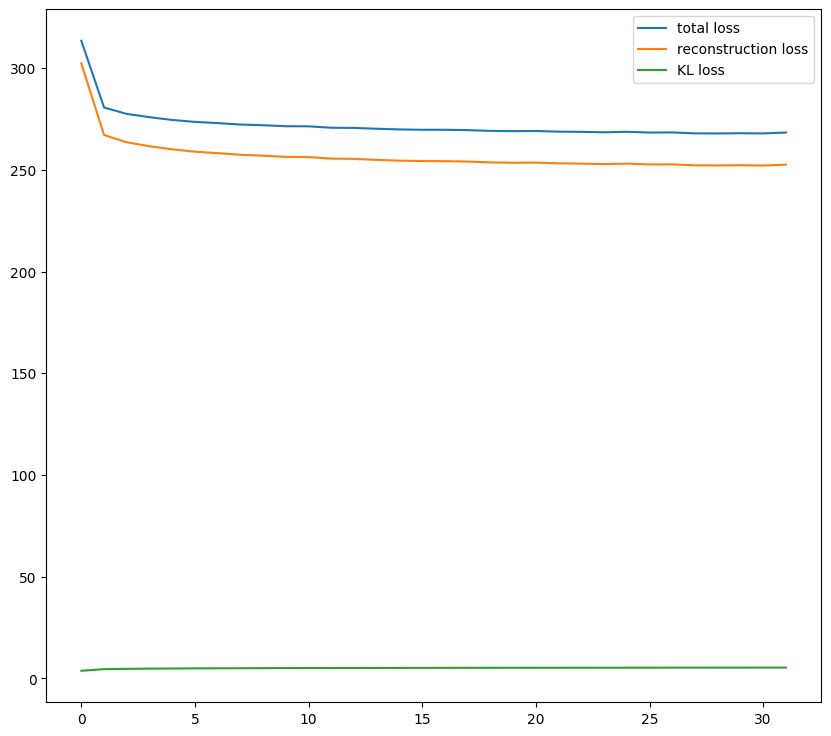

In [39]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

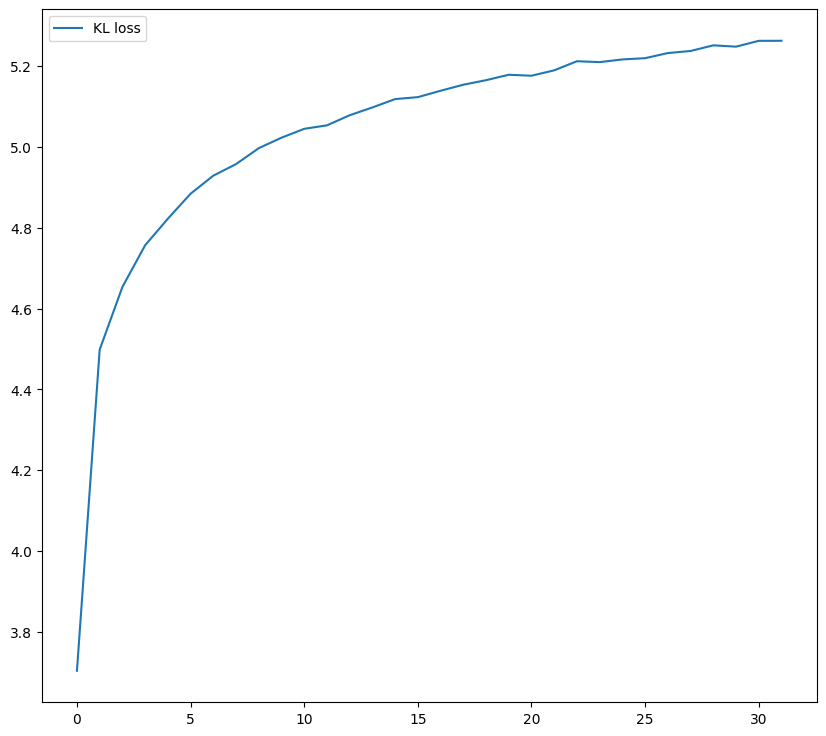

In [40]:
# Vamos ampliar a perda de KL para que possamos ver melhor

plt.figure(figsize=(10, 9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

# Resultados

Após treinar o modelo, podemos gerar novas imagens amostrando pontos aleatórios do espaço latente e passando-os pelo decoder. Podemos também visualizar o espaço latente em 2D para entender como as diferentes classes de roupas estão distribuídas.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


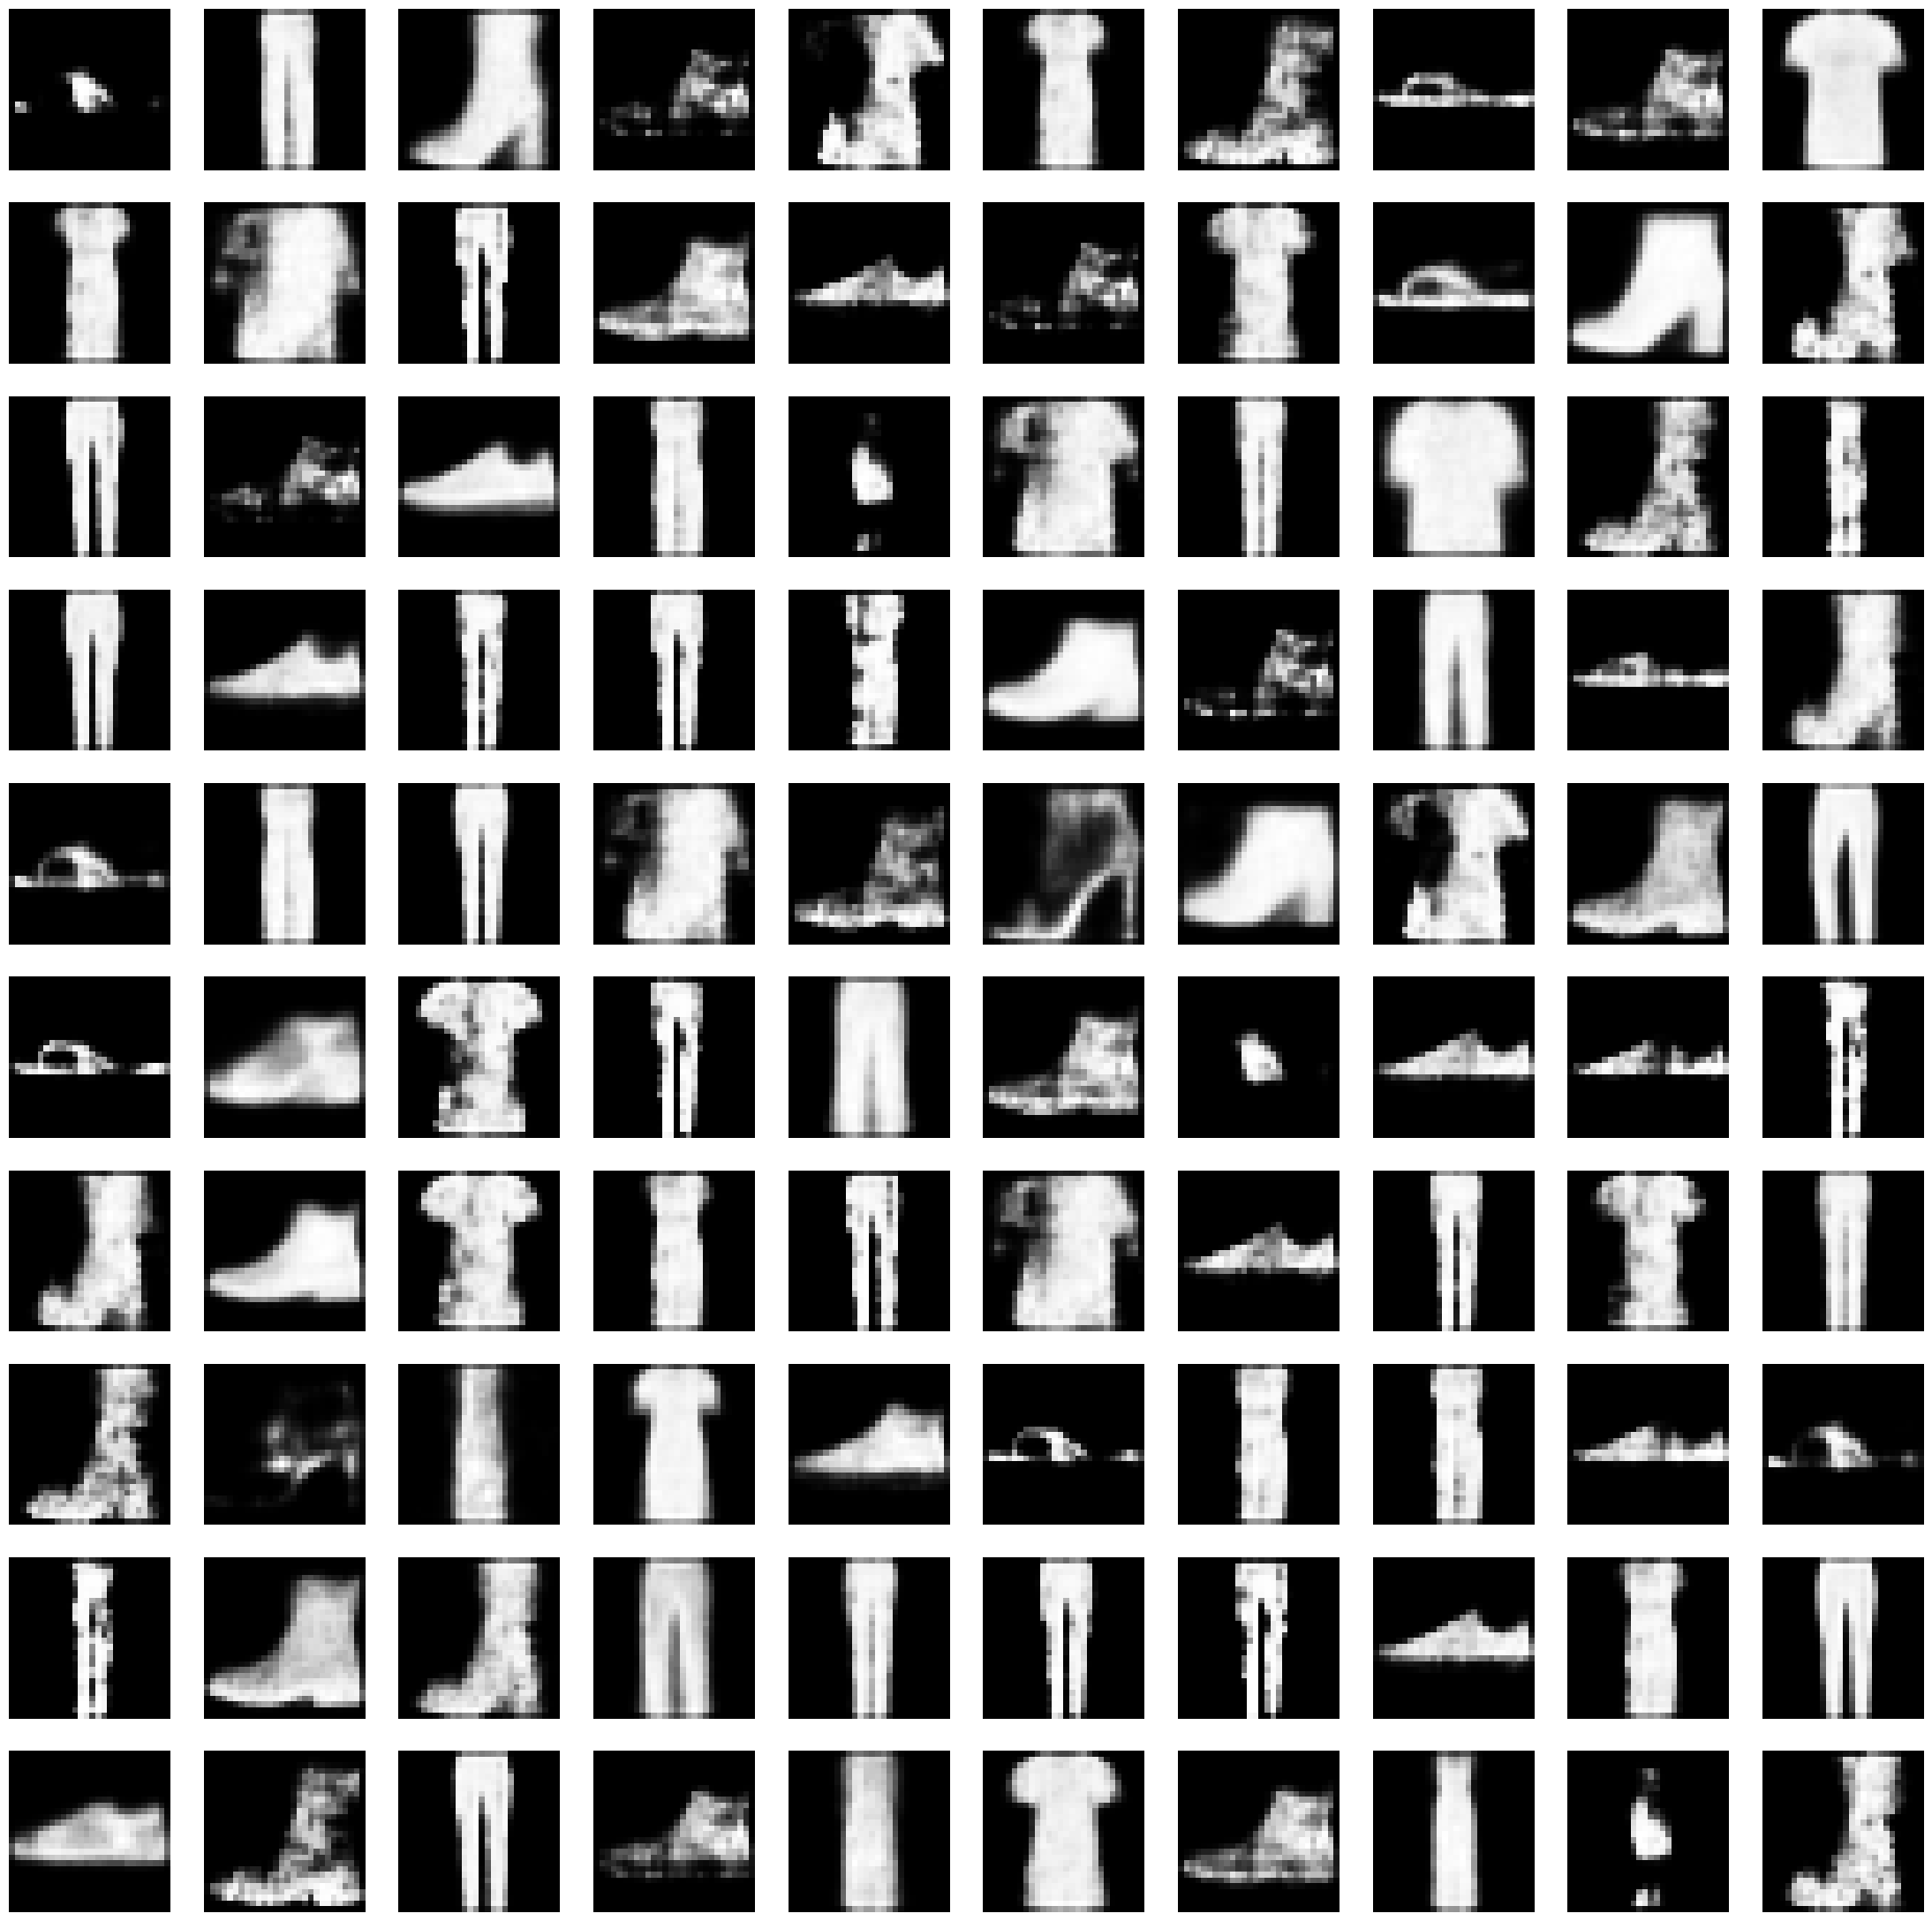

In [41]:
z = np.random.normal(loc=0, scale=4, size=(100,2))
synth = vae.decoder.predict(z)

plt.figure(figsize=(28,28))

for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
    plt.axis('off')

plt.show();

In [42]:
# Mapearemos uma imagem de uma categoria através do codificador e observaremos a saída.
# Em seguida, usaremos essas saídas para instruir condicionalmente o decodificador a amostrar de uma categoria específica.

idx = 1280 # arbitrariamente
batch = np.expand_dims(x_train[idx], axis=0)
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255
print(batchOfImages.shape)

# obtém z(mu,sigma) para a imagem dada
_, _, z = vae.encoder.predict(batchOfImages)

# agora reconstrua uma imagem semelhante
synth = vae.decoder.predict([z])

z

(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


array([[-1.6540778,  1.1806158]], dtype=float32)

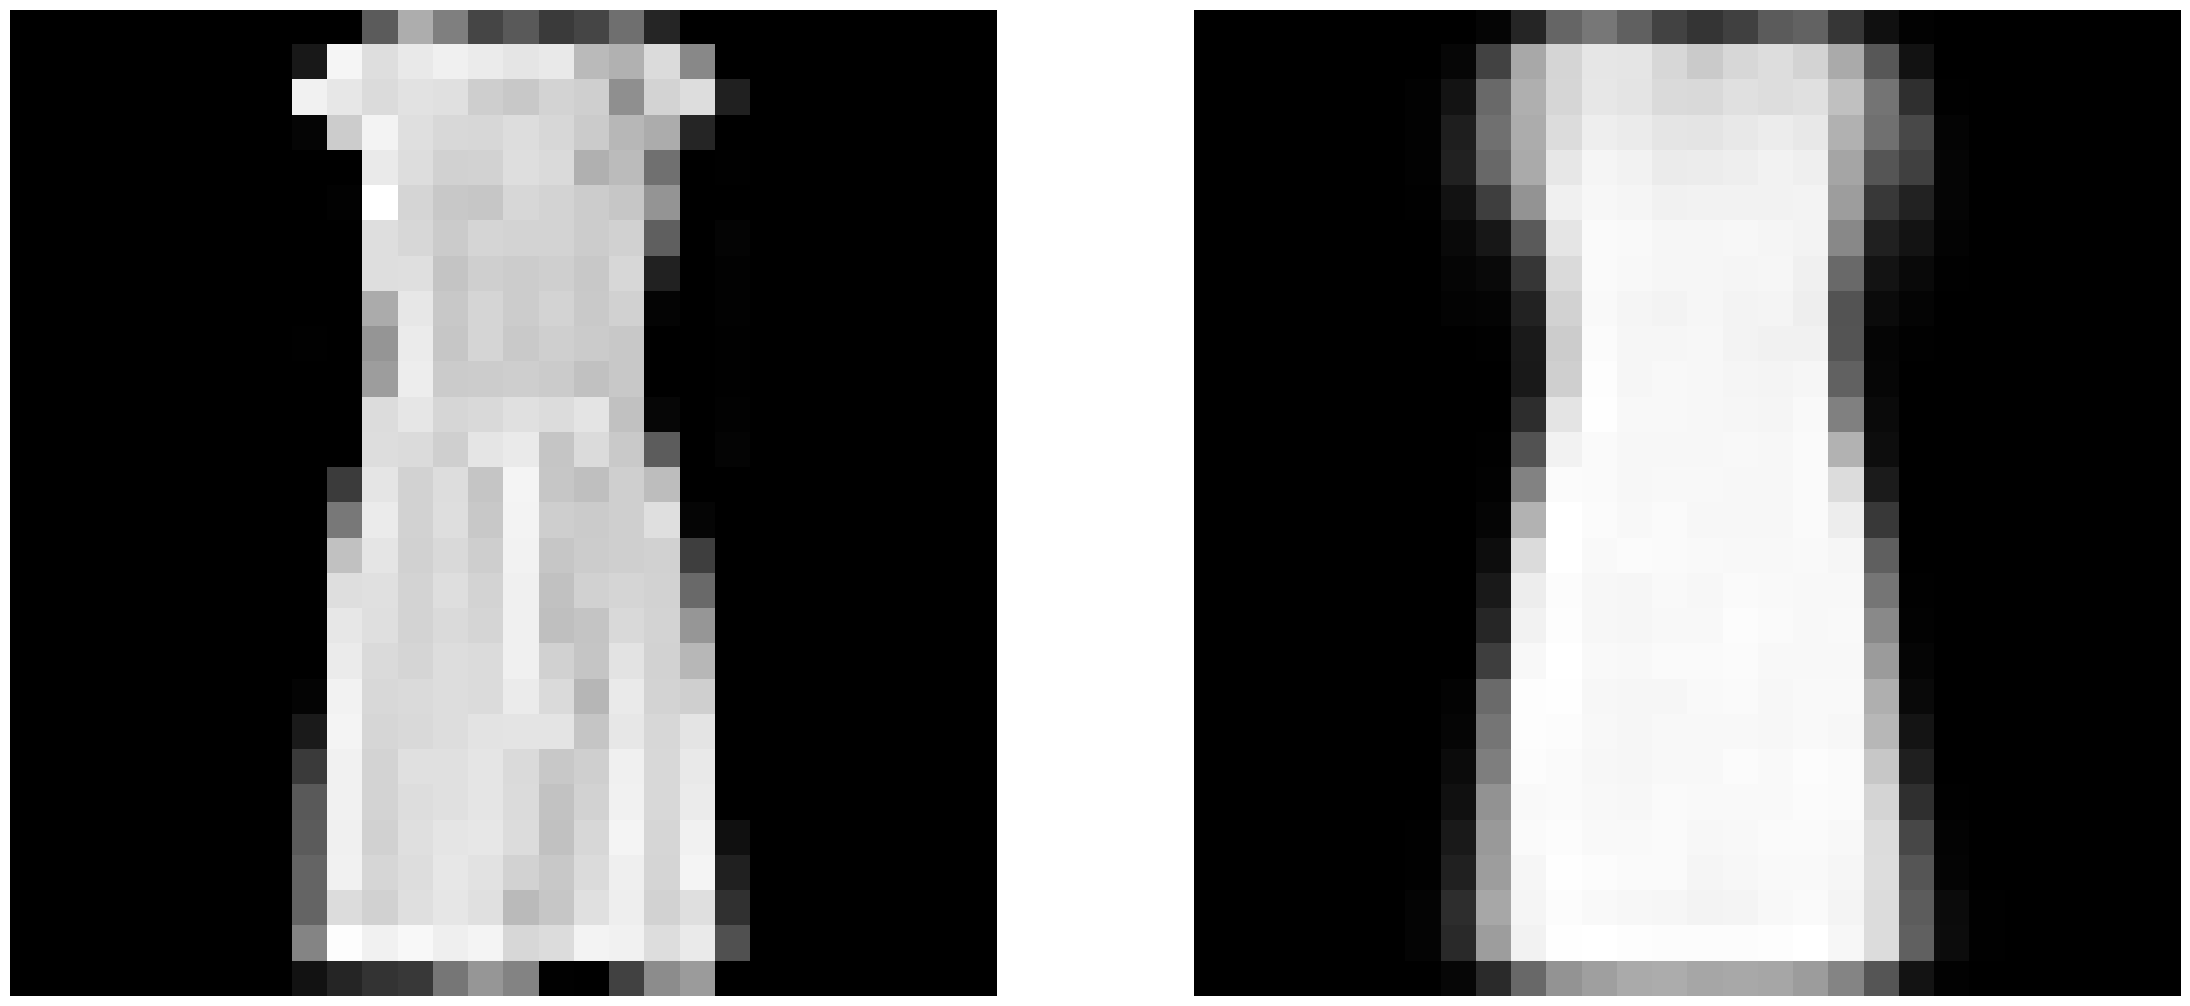

In [43]:
plt.figure(figsize=(28, 28))

# imagem original
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap="Greys_r")

# imagem reconstruída
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap="Greys_r")
plt.show();

2188/2188 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


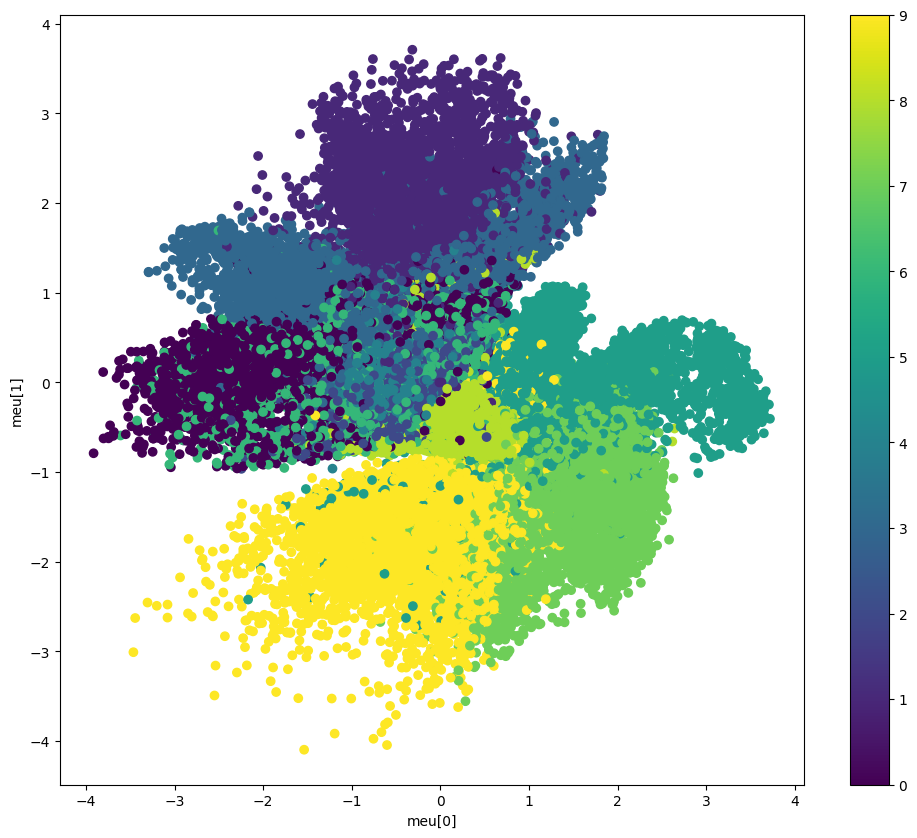

In [44]:
"""
O VAE pode ser usado no aprendizado não supervisionado de texto grande ou corpus de imagens não rotuladas de modo a agrupar as amostras em categorias
"""

labels = np.concatenate([y_train, y_test], axis=0)
meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(12, 10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.colorbar()
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
plt.show();